In [1]:
import pandas as pd

# Load data

In [2]:
data_fpath = '../av_survey_data/bikepgh_av_survey.csv'
data = pd.read_csv(data_fpath, index_col=0)
print(data.shape)
print(data.columns)

(1608, 32)
Index(['age', 'av_disclose_performance', 'av_reduce_injuries',
       'av_report_safety', 'av_school_zone', 'av_share_data', 'av_speed_limit',
       'av_two_drivers', 'bikegph_member', 'bikepgh_position',
       'bikepgh_should_advocate', 'elaborate_bikepgh_position', 'end_date',
       'familiar_av_tech', 'feel_safe_avs', 'feel_safe_cars',
       'herzberg_death_change_opinion', 'interacted_av_biking',
       'interacted_av_walking', 'interaction_details',
       'negative_av_interaction', 'other_av_regulations', 'other_comments',
       'own_car', 'own_smartphone', 'paying_attention_av_news',
       'positive_av_interaction', 'regulate_av_testing', 'start_date',
       'thoughts_pgh_av_testing', 'year', 'zipcode'],
      dtype='object')


# Get open-ended comments

In [3]:
text_colnames = [
    'interaction_details',
    'positive_av_interaction',
    'negative_av_interaction',
    'other_av_regulations',
    'elaborate_bikepgh_position',
    'other_comments',
                ]

for colname in text_colnames:
    print(f'{colname}: {data[colname].count()}')

interaction_details: 943
positive_av_interaction: 439
negative_av_interaction: 328
other_av_regulations: 521
elaborate_bikepgh_position: 507
other_comments: 637


## How many words per comment? How many total words for each text column?

In [4]:
preprocessed = {}

for colname in text_colnames:
    preprocessed[colname] = data[colname].str.split().apply(lambda d: d if isinstance(d, list) else []) # whitespace tokenization
    total_words = sum([len(row) for row in preprocessed[colname].tolist()])
    avg_words = total_words/data[colname].count()
    print(f'{colname}:')
    print(f'\ttotal words: {total_words}')
    print(f'\tavg words: {avg_words}')
    print()

interaction_details:
	total words: 21180
	avg words: 22.460233297985155

positive_av_interaction:
	total words: 5512
	avg words: 12.555808656036447

negative_av_interaction:
	total words: 3650
	avg words: 11.128048780487806

other_av_regulations:
	total words: 9482
	avg words: 18.19961612284069

elaborate_bikepgh_position:
	total words: 22254
	avg words: 43.89349112426036

other_comments:
	total words: 20497
	avg words: 32.17739403453689



# Learn topics

In [104]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords

colname = 'interaction_details'
filtered_data = data[data[colname].map(lambda x: isinstance(x, str))].copy()
print(f"Filtered to {len(filtered_data)} entries")
docs = filtered_data[colname].tolist()
tokenized_docs = [list(tokenize(remove_stopwords(doc.lower()))) for doc in docs]

dictionary = Dictionary(tokenized_docs)
print(f"Found {len(dictionary.token2id)} unique words")

corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

lda = LdaModel(corpus, id2word=dictionary, num_topics=10)

Filtered to 943 entries
Found 1932 unique words


# Print top words/topic

In [95]:
word_topics = lda.show_topics()
word_topics

[(0,
  '0.022*"av" + 0.020*"vehicle" + 0.015*"i" + 0.015*"avs" + 0.011*"ve" + 0.009*"human" + 0.009*"safer" + 0.009*"streets" + 0.008*"road" + 0.008*"drivers"'),
 (1,
  '0.018*"speed" + 0.016*"av" + 0.015*"human" + 0.014*"drivers" + 0.012*"limit" + 0.012*"avs" + 0.012*"t" + 0.012*"i" + 0.012*"cars" + 0.010*"vehicle"'),
 (2,
  '0.018*"notable" + 0.018*"av" + 0.018*"vehicles" + 0.017*"vehicle" + 0.016*"t" + 0.011*"autonomous" + 0.011*"i" + 0.010*"strip" + 0.009*"ordinary" + 0.009*"stop"'),
 (3,
  '0.021*"av" + 0.015*"vehicle" + 0.014*"issues" + 0.012*"stopped" + 0.011*"vehicles" + 0.011*"street" + 0.011*"lane" + 0.011*"passed" + 0.011*"bike" + 0.010*"driving"'),
 (4,
  '0.026*"car" + 0.025*"av" + 0.023*"normal" + 0.014*"notable" + 0.013*"like" + 0.012*"avs" + 0.010*"autonomous" + 0.009*"vehicle" + 0.009*"t" + 0.009*"vehicles"'),
 (5,
  '0.014*"av" + 0.014*"bike" + 0.012*"s" + 0.012*"turn" + 0.011*"car" + 0.011*"driver" + 0.011*"i" + 0.010*"t" + 0.010*"ve" + 0.010*"crosswalk"'),
 (6,
  '0

# Print top documents/topic

In [98]:
def get_top_docs(lda, docs, n_docs=5):
    document_topics = [lda.get_document_topics(bow) for bow in corpus]
    lines = []
    for topic_ind in range(lda.num_topics):
#         print(f"Topic {topic_ind}")
        for doc_ind, dist in sorted(zip(list(range(len(document_topics))), document_topics), reverse=True, key=lambda x: abs(dict(x[1]).get(topic_ind, 0.0)))[:n_docs]:
            topic_proportion = dict(dist).get(topic_ind, 0.0)
            lines.append([topic_ind, word_topics[topic_ind][1], doc_ind, docs[doc_ind], topic_proportion])
#             print(f"{doc_ind}\t{topic_proportion}")

    return pd.DataFrame(lines, columns=['topic', 'topic_top_words', 'document_index', 'document', 'topic_proportion'])

In [ ]:
pd.set_option('display.max_colwidth', -1)
get_top_docs(lda, docs, n_docs=5)

In [113]:
document_topics = [lda.get_document_topics(bow) for bow in corpus]
id2index = dict(zip(filtered_data.index, range(len(filtered_data))))

# Assign top topics to docs, graph other variables
filtered_data['top_topic'] = filtered_data.index.map(lambda x: sorted(document_topics[id2index[x]], key=lambda x: x[1], reverse=True)[0][0])

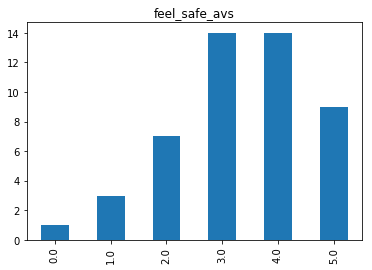

In [128]:
%matplotlib inline

import matplotlib.pyplot as plt

topic = 3
compared_column = 'feel_safe_avs'
topic_data = filtered_data[filtered_data['top_topic']==topic].copy()
# print(topic_data[compared_column].value_counts().sort_index())
topic_data[compared_column].value_counts().sort_index().plot.bar().set_title(compared_column)

Topic 3 seems to report more issues with the AV interactions

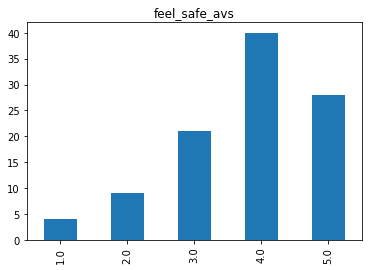

In [142]:
%matplotlib inline

import matplotlib.pyplot as plt

topic = 9
compared_column = 'feel_safe_avs'
topic_data = filtered_data[filtered_data['top_topic']==topic].copy()
# print(topic_data[compared_column].value_counts().sort_index())
topic_data[compared_column].value_counts().sort_index().plot.bar().set_title(compared_column)